In [25]:
import copy
import os
from os.path import join as oj
import glob
import argparse
import pickle as pkl
import time
import warnings
from scipy import stats
import dask
from dask.distributed import Client
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
from collections import defaultdict
from typing import Callable, List, Tuple
import itertools
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, mean_squared_error

sys.path.append(".")
sys.path.append("..")
sys.path.append("../../imodels/")

warnings.filterwarnings("ignore", message="Bins whose width")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error

from imodels.importance import RandomForestPlusRegressor, RandomForestPlusClassifier, \
    RidgeRegressorPPM, LassoRegressorPPM, IdentityTransformer
from imodels.importance.rf_plus import _fast_r2_score
import seaborn as sns
from util import ModelConfig, FIModelConfig, tp, fp, neg, pos, specificity_score, auroc_score, auprc_score, compute_nsg_feat_corr_w_sig_subspace, apply_splitting_strategy
import shap
import sklearn

In [26]:
def sample_normal_X_subgroups(n, d, mean, scale):
    """
    :param n: Number of samples
    :param d: Number of features
    :param mean: Nested list of mean of normal distribution for each subgroup
    :param scale: Nested ist of scale of normal distribution for each subgroup
    :return:
    """
    assert len(mean[0]) == len(scale[0]) == d
    num_groups = len(mean)
    result = []
    group_size = n // num_groups
    for i in range(num_groups):
        X = np.zeros((group_size, d))
        for j in range(d):
            X[:, j] = np.random.normal(mean[i][j], scale[i][j], size=group_size)
        result.append(X)
    return np.vstack(result)

In [27]:
def generate_random_shuffle(data, seed):
    """
    Randomly shuffle each column of the data.
    """
    np.random.seed(seed)
    return np.array([np.random.permutation(data[:, i]) for i in range(data.shape[1])]).T


def ablation(data, feature_importance, mode, num_features, seed):
    """
    Replace the top num_features max feature importance data with random shuffle for each sample
    """
    assert mode in ["max", "min"]
    fi = feature_importance.to_numpy()
    shuffle = generate_random_shuffle(data.copy(), seed)
    if mode == "max":
        indices = np.argsort(-fi)
    else:
        indices = np.argsort(fi)
    data_copy = data.copy()
    for i in range(data.shape[0]):
        for j in range(num_features):
            data_copy[i, indices[i,j]] = shuffle[i, indices[i,j]]
    return data_copy


In [28]:
def tree_shap_local(X, y, fit):
    """
    Compute average treeshap value across observations.
    Larger absolute values indicate more important features.
    :param X: design matrix
    :param y: response
    :param fit: fitted model of interest (tree-based)
    :return: dataframe of shape: (n_samples, n_features)
    """
    explainer = shap.TreeExplainer(fit)
    shap_values = explainer.shap_values(X, check_additivity=False)
    if sklearn.base.is_classifier(fit):
        # Shape values are returned as a list of arrays, one for each class
        def add_abs(a, b):
            return abs(a) + abs(b)
        results = reduce(add_abs, shap_values)
    else:
        results = abs(shap_values)
    result_table = pd.DataFrame(results, columns=[f'Feature_{i}' for i in range(X.shape[1])])

    return result_table

In [29]:
# Define the data
n = 200
d = 10
mean = [[0]*10, [10]*10]
scale = [[1]*10,[1]*10]
s = 5
X = sample_normal_X_subgroups(n, d, mean, scale)
beta = np.concatenate((np.ones(s), np.zeros(d-s)))
y = np.matmul(X, beta)
split_seed = 0
X_train, X_tune, X_test, y_train, y_tune, y_test = apply_splitting_strategy(X, y, "train-test", split_seed)

#Define the model and fit
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_regressor.fit(X_train, y_train)
rf_plus_model = RandomForestPlusRegressor(rf_model=rf_regressor, include_raw=False)
rf_plus_model.fit(X_train, y_train)


# initialize the metric results
metric_results = {}

y_pred = rf_regressor.predict(X_test)
metric_results['MSE_before_ablation'] = mean_squared_error(y_test, y_pred)

# Ablation
score = rf_plus_model.get_mdi_plus_scores(X_test, y_test, lfi=True, lfi_abs = "outside", sample_split=None)
local_fi_score = score["lfi"]
ascending = True # False for MDI
imp_vals = copy.deepcopy(local_fi_score)
imp_vals[imp_vals == float("-inf")] = -sys.maxsize - 1
imp_vals[imp_vals == float("inf")] = sys.maxsize - 1
seed = 0#np.random.randint(0, 100000)
for i in range(X_test.shape[1]):
    if ascending:
        ablation_X_test = ablation(X_test, imp_vals, "max", i+1, seed)
    else:
        ablation_X_test = ablation(X_test, imp_vals, "min", i+1, seed)
    metric_results[f'MSE_after_ablation_{i+1}'] = mean_squared_error(y_test, rf_regressor.predict(ablation_X_test))

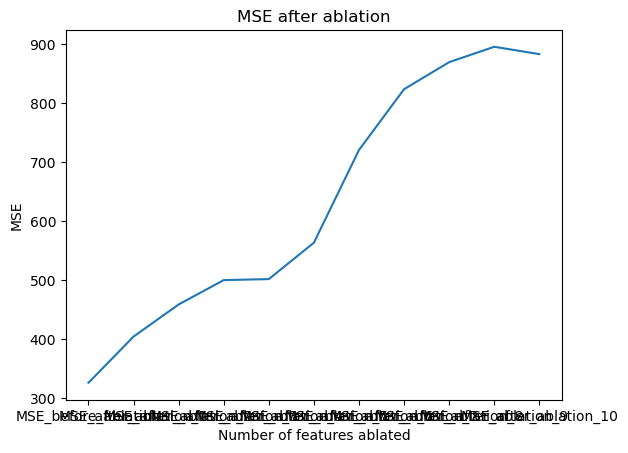

In [30]:
# plot metric_results
fig, ax = plt.subplots()
ax.plot(list(metric_results.keys()), list(metric_results.values()))
ax.set_xlabel('Number of features ablated')
ax.set_ylabel('MSE')
ax.set_title('MSE after ablation')
plt.show()

In [31]:
metric_results = {}
y_pred = rf_regressor.predict(X_test)
metric_results['MSE_before_ablation'] = mean_squared_error(y_test, y_pred)
local_fi_score = tree_shap_local(X_test, y_test, rf_regressor)
ascending = True # False for MDI
imp_vals = copy.deepcopy(local_fi_score)
imp_vals[imp_vals == float("-inf")] = -sys.maxsize - 1
imp_vals[imp_vals == float("inf")] = sys.maxsize - 1
seed = np.random.randint(0, 100000)
for i in range(X_test.shape[1]):
    if ascending:
        ablation_X_test = ablation(X_test, imp_vals, "max", i+1, seed)
    else:
        ablation_X_test = ablation(X_test, imp_vals, "min", i+1, seed)
    metric_results[f'MSE_after_ablation_{i+1}'] = mean_squared_error(y_test, rf_regressor.predict(ablation_X_test))

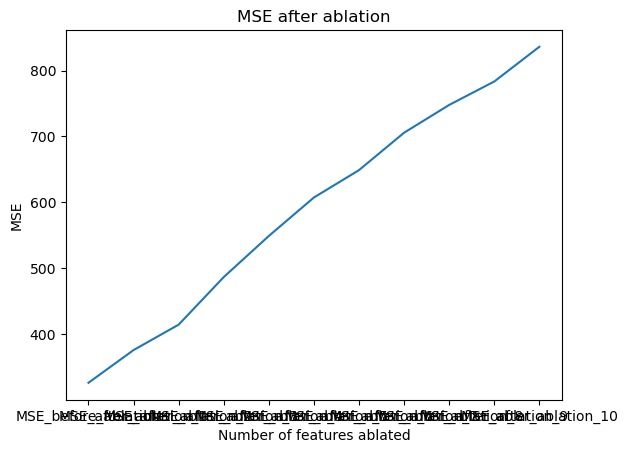

In [32]:
# plot metric_results
fig, ax = plt.subplots()
ax.plot(list(metric_results.keys()), list(metric_results.values()))
ax.set_xlabel('Number of features ablated')
ax.set_ylabel('MSE')
ax.set_title('MSE after ablation')
plt.show()